## Image segmentation with fastai

In [118]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

In [2]:
path = os.getcwd()
img_path = path+'/data/h5'
path_img = img_path+'/img_wmasks'
path_lbl = path+'/data/h5/masks2'

## Data

In [3]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks/9370400_5518400.png'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks/8589200_5538000.png'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks/8507600_5765200.png')]

In [4]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/9295200_5556000_mask.tif'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/8820000_5988800_mask.tif'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/9301600_5562000_mask.tif')]

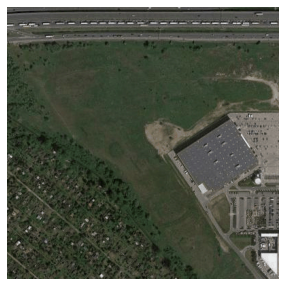

In [5]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [6]:
get_y_fn = lambda x: path_lbl+f'/{x.stem}_mask.tif'

In [7]:
lbl_names[1]

PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/masks2/8820000_5988800_mask.tif')

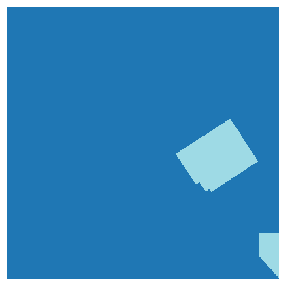

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([400, 400]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
mask.size

torch.Size([400, 400])

In [11]:
codes = array(['Background' , 'Building'])

In [12]:
codes

array(['Background', 'Building'], dtype='<U10')

In [13]:
mask.data.sum()

tensor(8457)

## Datasets

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7594MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [17]:
data.valid_dl = data.valid_dl.new(shuffle=True)

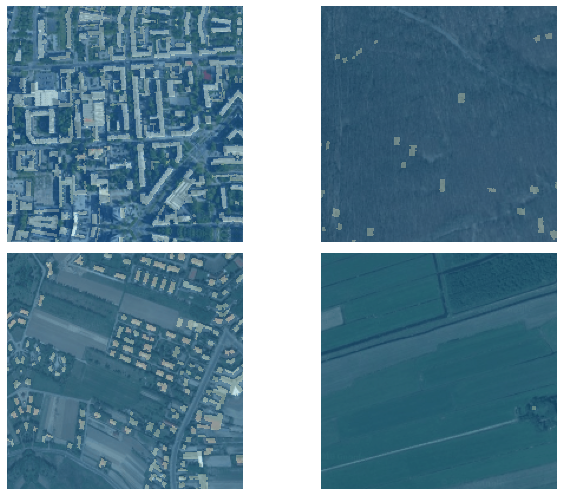

In [18]:
data.show_batch(2, figsize=(10,7))

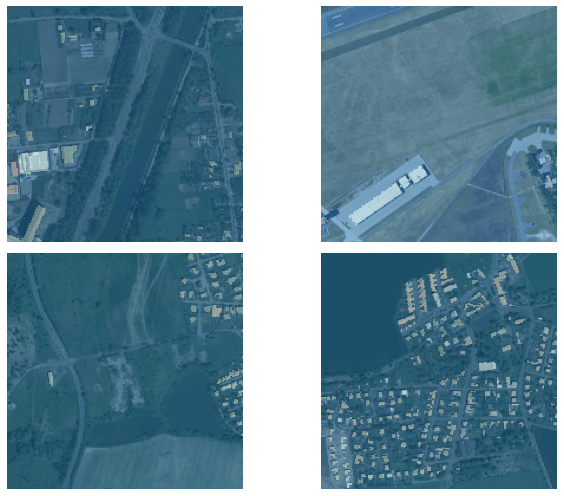

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_camvid

In [22]:
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


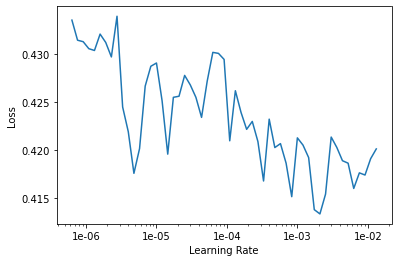

In [30]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [32]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.265417,0.243372,0.324725,03:31
1,0.246922,0.250347,0.514362,03:17
2,0.232454,0.220808,0.490394,03:17
3,0.227873,0.216771,0.508521,03:17
4,0.229264,0.215252,0.536646,03:18
5,0.226656,0.218778,0.496708,03:18
6,0.232239,0.217728,0.561472,03:18
7,0.228866,0.212635,0.578099,03:18
8,0.213661,0.208962,0.576201,03:19
9,0.206083,0.197514,0.572087,03:18


In [33]:
learn.save('stage-1')

In [34]:
learn.load('stage-1');

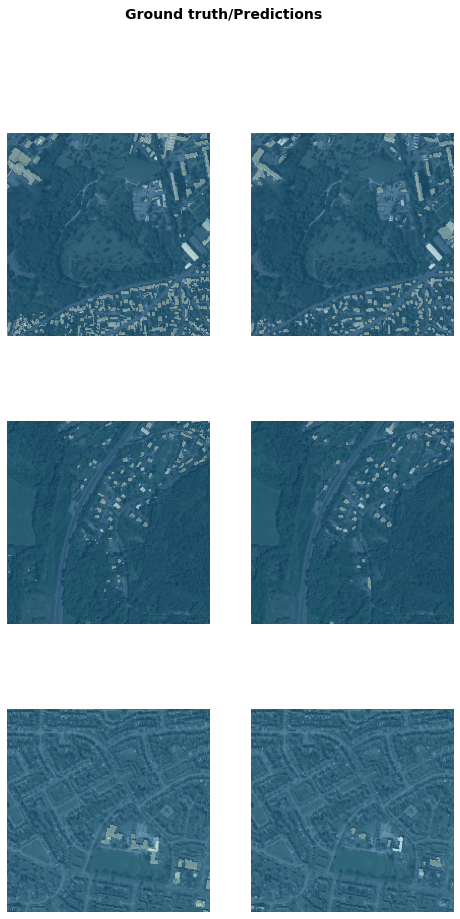

In [35]:
learn.show_results(rows=3, figsize=(8,15))

In [36]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [38]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.206849,0.196173,0.561892,03:37
1,0.195588,0.196012,0.578121,03:30
2,0.194290,0.194718,0.584786,03:30
3,0.203412,0.193067,0.568944,03:31
4,0.193004,0.192269,0.571688,03:31
5,0.202558,0.192248,0.574433,03:31
6,0.202170,0.192402,0.561554,03:31
7,0.186901,0.194372,0.536761,03:34
8,0.204457,0.191367,0.547763,03:31
9,0.196480,0.192179,0.604182,03:31


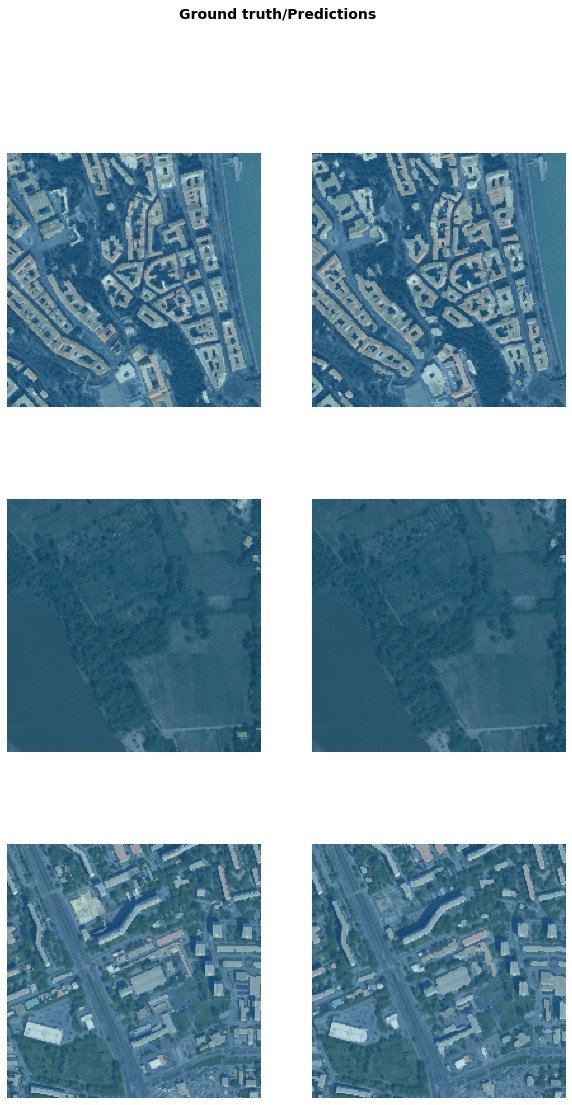

In [40]:
learn.show_results(rows=3, figsize=(10,18))

In [42]:
learn.save('stage-2');


In [86]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: /projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks;

Valid: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: /projects/qg35/jlgao2/FYP-Sandbox/data/h5/img_wmasks;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_s

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [26]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=3
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 6993MB of GPU RAM free


In [27]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [46]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


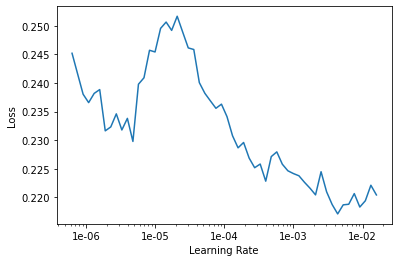

In [47]:
lr_find(learn)
learn.recorder.plot()

In [48]:
lr=1e-3

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.192988,0.194877,0.563373,11:03
1,0.206289,0.189780,0.586875,11:00
2,0.197930,0.188354,0.594897,11:00
3,0.183384,0.187282,0.636533,11:01
4,0.188211,0.185410,0.616907,11:01
5,0.196201,0.183721,0.607978,11:03
6,0.195956,0.181219,0.601281,11:01
7,0.180226,0.181549,0.616118,11:01
8,0.195746,0.179340,0.641098,11:00
9,0.180412,0.176606,0.623988,11:01


In [50]:
learn.save('stage-1-big')

In [29]:
learn.load('stage-1-big');

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(1e-6,lr/10)

In [32]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.178157,0.177290,0.627877,23:40
1,0.194858,0.184552,0.541604,23:35
2,0.174221,0.235006,0.601460,23:36
3,0.208536,0.201562,0.565716,23:37
4,0.190903,0.184813,0.603753,23:36
5,0.180338,0.194739,0.575114,23:36
6,0.194246,0.205351,0.607111,23:37
7,0.173586,0.268123,0.581080,23:37
8,0.186383,0.388126,0.591671,23:37
9,0.195230,0.969050,0.591985,23:37


In [33]:
learn.save('stage-2-big')

In [29]:
learn.load('stage-2-big');

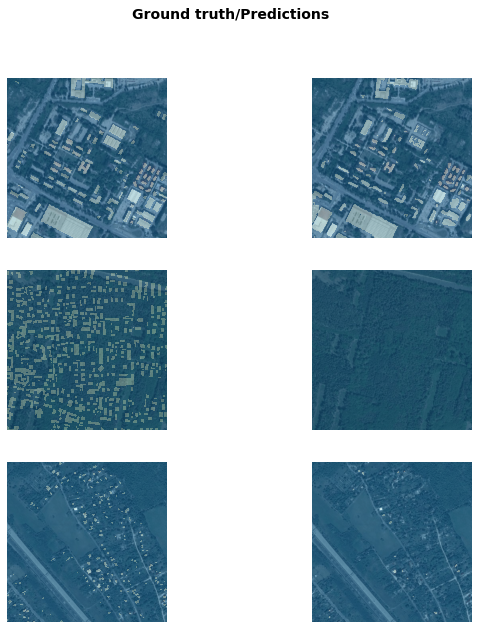

In [30]:
learn.show_results(rows=3, figsize=(10,10))

In [31]:
learn.export()

In [39]:
learn = load_learner(path_img)

## Inference

In [46]:
path_infer = img_path+'/S2-esrgan'
il = ImageList.from_folder(path_infer)

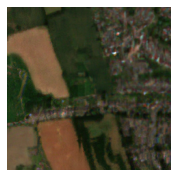

In [76]:
il[5].show()

In [77]:
learn.predict(il[5])

(ImageSegment (1, 400, 400),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]),
 tensor([[[0.9872, 0.9932, 0.9962,  ..., 0.7931, 0.7680, 0.7877],
          [0.9928, 0.9968, 0.9961,  ..., 0.8328, 0.7683, 0.7460],
          [0.9961, 0.9973, 0.9967,  ..., 0.8810, 0.8162, 0.8280],
          ...,
          [0.9888, 0.9889, 0.9843,  ..., 0.9718, 0.9751, 0.9703],
          [0.9844, 0.9840, 0.9830,  ..., 0.9772, 0.9752, 0.9520],
          [0.9792, 0.9852, 0.9861,  ..., 0.9763, 0.9578, 0.9481]],
 
         [[0.0128, 0.0068, 0.0038,  ..., 0.2069, 0.2320, 0.2123],
          [0.0072, 0.0032, 0.0039,  ..., 0.1672, 0.2317, 0.2540],
          [0.0039, 0.0027, 0.0033,  ..., 0.1190, 0.1838, 0.1720],
          ...,
          [0.0112, 0.0111, 0.0157,  ..., 0.0282, 0.0249, 0.0297],
          [0.0156, 0.0160, 0.0170,  ..., 0.0

In [83]:
(il[5]).shape

torch.Size([3, 240, 240])

fastai.vision.image.Image

In [130]:
from PIL import ImageOps
from PIL import Image as PImage
import torchvision.transforms as tfms

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = PImage.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

def fast2pil(img):
    return tfms.ToPILImage()(img.data).convert("RGB")

def pil2fast(img):  
    return Image((tfms.ToTensor()(img)))

im.thumbnail(size, Image.ANTIALIAS)

In [172]:
il.items[150]

PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/S2-esrgan/8288000_5495000_S10(3)_rlt.png')

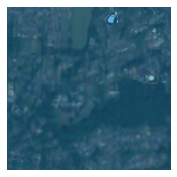

In [176]:
idx = 120
im = il[idx]
im_new = fast2pil(im)
im_new = im_new.resize((400,400))
#im_new = add_margin(fast2pil(im), 80, 80, 80, 80, (0, 0, 0))
im_new2 = Image(tfms.ToTensor()(im_new))
im_new2.show(y=learn.predict(im_new2)[0])

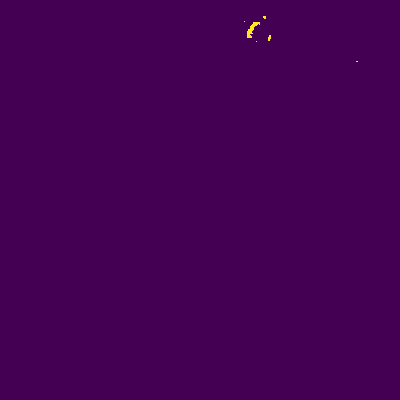

In [177]:
learn.predict(im_new2)[0]

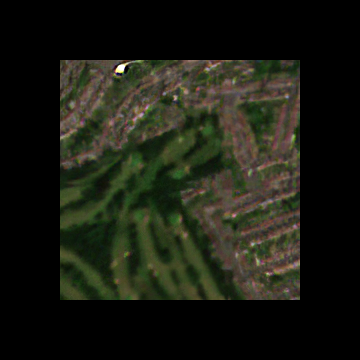

In [133]:
im_new2

In [173]:
s2_raw_ex = "/projects/qg35/jlgao2/FYP-Sandbox/data/h5/S2-esrgan/8288000_5495000_S10(3)_rlt.png"
small_img = PImage.open(s2_raw_ex)

In [ ]:
small.